In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class CouplingLayer(nn.Module):
    def __init__(self, coupling_function, chunker):
        super(CouplingLayer, self).__init__()
        self.coupling_function = coupling_function
        self.chunker = chunker

    def forward(self, x):
        x1, x2 = self.chunker(x)
        y1 = x1
        y2 = self._coupling_transform(x1, x2)
        return self.chunker.invert(y1, y2)
    
    def inverse(self, y):
        y1, y2 = self.chunker(y)
        x1 = y1
        x2 = self._inverse_coupling_transform(y1, y2)
        return self.chunker.invert(x1, x2)
    
    def log_det_jacobian(self, x):
        x1, x2 = self.chunker(x)
        return self._log_det_jacobian(x1, x2)
    
    def _coupling_transform(self, x1, x2):
        raise NotImplementedError("Subclasses should implement this method.")
    
    def _inverse_coupling_transform(self, y1, y2):
        raise NotImplementedError("Subclasses should implement this method.")
    
    def _log_det_jacobian(self, x1, x2):
        raise NotImplementedError("Subclasses should implement this method.")
    
class AdditiveCouplingLayer(CouplingLayer):
    def __init__(self, coupling_function, chunker):
        super(AdditiveCouplingLayer, self).__init__(coupling_function, chunker)

    def _coupling_transform(self, x1, x2):
        return x2 + self.coupling_function(x1)
    
    def _inverse_coupling_transform(self, y1, y2):
        return y2 - self.coupling_function(y1)

    def _log_det_jacobian(self, x1, x2):
        return torch.zeros(x1.size(0), device=x1.device)  


class ScalingCouplingLayer(CouplingLayer):
    def __init__(self, dim):
        self.dim = dim
        coupling_function = lambda x, s : x * torch.exp(s)
        super(ScalingCouplingLayer, self).__init__(coupling_function, None)
        
        self.log_scaling_factors = nn.Parameter(torch.ones(dim))

    def forward(self, x):
        y  = self.coupling_function(x, self.log_scaling_factors)
        return y
    
    def inverse(self, y):
        x = self.coupling_function(y, -self.log_scaling_factors)
        return x
    
    def log_det_jacobian(self, x):
        return self.log_scaling_factors.sum(dim=0).repeat(x.shape[0])
    
class Chunker(CouplingLayer):
    def __init__(self):
        super(Chunker, self).__init__(None, None)
    
    def forward(self, x):
        raise NotImplementedError("Subclasses should implement this method.")
    
    def inverse(self, y):
        raise NotImplementedError("Subclasses should implement this method.")
    
    def invert(self, y1, y2):
        raise NotImplementedError("Subclasses should implement this method.")
        
class HalfChunker(Chunker):
    def __init__(self, permute=True):
        self.permute = permute
        super(HalfChunker, self).__init__()
    
    def forward(self, x):
        x1, x2 = x.chunk(2, dim=1)
        if self.permute:
            return x2, x1
        else:
            return x1, x2
    
    def inverse(self, y):
        y1, y2 = y.chunk(2, dim=1)
        if self.permute:
            return y2, y1
        else:
            return y1, y2
    
    def _log_det_jacobian(self, x1, x2):
        return torch.zeros(x1.size(0), device=x1.device)
    
    def invert(self, y1, y2):
        if self.permute:
            return torch.cat((y2, y1), dim=1)
        else:
            return torch.cat((y1, y2), dim=1)

#NOT USED IN THIS NOTEBOOK        
class OddEvenChunker(Chunker):
    def __init__(self, permute=True):
        self.permute = permute
        super(OddEvenChunker, self).__init__()
    
    def forward(self, x):
        x_odd = x[:, 1::2]
        x_even = x[:, 0::2]
        
        if self.permute:
            return x_odd, x_even
        else:
            return x_even, x_odd
    
    def inverse(self, y):
        y_odd = y[:, 1::2]
        y_even = y[:, 0::2]
        
        if self.permute:
            return y_even, y_odd
        else:
            return y_odd, y_even
    
    def _log_det_jacobian(self, x_odd, x_even):
        return torch.zeros(x_odd.size(0), device=x_odd.device)
        
    def invert(self, y1, y2):
        batch_size = y1.size(0)
        num_features = y1.size(1) + y2.size(1)
        
        # Create an empty tensor to hold the intercalated values
        y = torch.empty((batch_size, num_features), device=y1.device, dtype=y1.dtype)
        
        if self.permute:
            y[:, 0::2] = y2  # Even positions
            y[:, 1::2] = y1  # Odd positions
        else:
            # Interleave y1 and y2
            y[:, 0::2] = y1  # Even positions
            y[:, 1::2] = y2  # Odd positions

        return y
    
class NICE_NormalizingFlow(nn.Module):
    # in the NICE paper, the latent distribution is a 1d distribution and we sample from it in N-dimensions independently
    def __init__(self, layers, latent_dim, latent_distribution, forward_transform=None, inverse_transform=None, device=None):
        super(NICE_NormalizingFlow, self).__init__()
        self.layers = nn.ModuleList(layers)
        self.latent_dim = latent_dim
        self.latent_distribution = latent_distribution
        self.forward_transform = forward_transform
        self.inverse_transform = inverse_transform
    
        if device is None:
            device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
        self.device = device
        self.to(device)
        
        self.latent_distribution.loc = self.latent_distribution.loc.to(self.device)
        self.latent_distribution.scale = self.latent_distribution.scale.to(self.device)
    
    def forward(self, x):
        log_det_jacobian = 0
        if self.forward_transform:
            x = self.forward_transform(x)
            
        for layer in self.layers:
            x = layer(x)
            log_det_jacobian += layer.log_det_jacobian(x)
        return x, log_det_jacobian
    
    def inverse(self, y):
        for layer in reversed(self.layers):
            y = layer.inverse(y)
        
        if self.inverse_transform:
            y = self.inverse_transform(y)
        return y

    def sample(self, n_samples):
        z = self.latent_distribution.sample((n_samples,self.latent_dim)).squeeze(-1)
        device = next(self.parameters()).device
        z = z.to(device)
        return self.inverse(z)
    
    def log_prob(self, x):
        z, log_det_jacobian = self.forward(x)
        return torch.sum(self.latent_distribution.log_prob(z), dim=-1) + log_det_jacobian

In [3]:
# Define the target distribution as a 2D sinusoidal distribution
def target_distribution(num_samples):
    x = torch.linspace(-2, 2, num_samples)
    y = torch.sin(3 * x) + 0.3 * torch.randn_like(x)  # Adding some noise
    samples = torch.stack([y, x], dim=1)
    return samples


# Generate samples from the target distribution
num_samples = 10000
perm = torch.randperm(num_samples)
target_samples = target_distribution(num_samples)
training_samples = target_samples[perm[:num_samples//2]]
val_samples = target_samples[perm[num_samples//2:]]

In [4]:
# Model Parameters
latent_dim = 2
latent_distribution = torch.distributions.Normal(torch.zeros(1), torch.ones(1))

# Define the coupling function (a simple rectified MLP)
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        return self.fc3(self.relu(self.fc2(self.relu(self.fc1(x)))))

# Create a list of coupling layers
layers = [
    AdditiveCouplingLayer(coupling_function=SimpleMLP(input_dim=1, hidden_dim=64, output_dim=1), chunker=HalfChunker(permute=False)),
    AdditiveCouplingLayer(coupling_function=SimpleMLP(input_dim=1, hidden_dim=64, output_dim=1), chunker=HalfChunker(permute=True)),
    AdditiveCouplingLayer(coupling_function=SimpleMLP(input_dim=1, hidden_dim=64, output_dim=1), chunker=HalfChunker(permute=False)),
    AdditiveCouplingLayer(coupling_function=SimpleMLP(input_dim=1, hidden_dim=64, output_dim=1), chunker=HalfChunker(permute=True)),
    
    ScalingCouplingLayer(2)
]

# Move the model to the GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate the NICE model
nice_model = NICE_NormalizingFlow(layers=layers, latent_dim=latent_dim, latent_distribution=latent_distribution, device=device)
print(nice_model)
print(device)

NICE_NormalizingFlow(
  (layers): ModuleList(
    (0-3): 4 x AdditiveCouplingLayer(
      (coupling_function): SimpleMLP(
        (fc1): Linear(in_features=1, out_features=64, bias=True)
        (fc2): Linear(in_features=64, out_features=64, bias=True)
        (fc3): Linear(in_features=64, out_features=1, bias=True)
        (relu): ReLU()
      )
      (chunker): HalfChunker()
    )
    (4): ScalingCouplingLayer()
  )
)
cuda


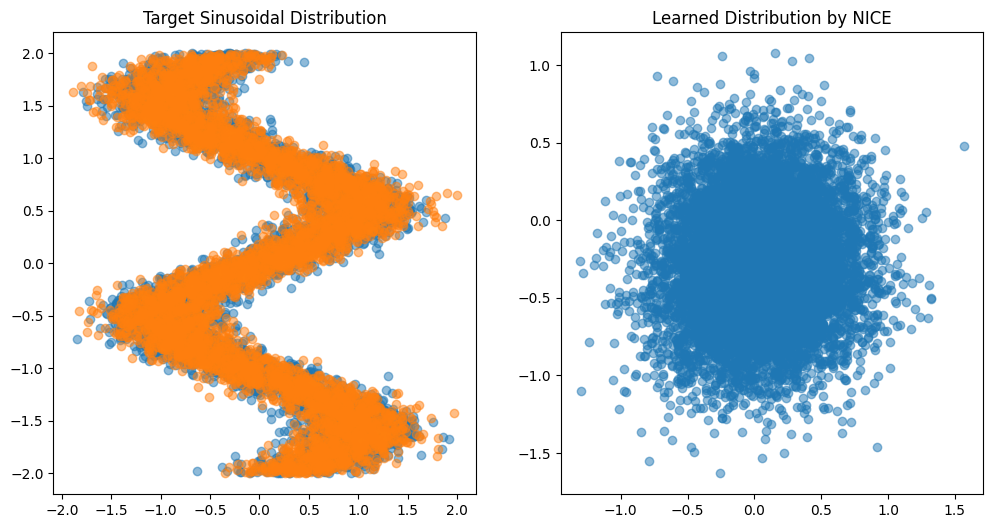

In [5]:
# Generate samples from the learned model
with torch.no_grad():
    learned_samples = nice_model.sample(num_samples).cpu()

# Plotting
plt.figure(figsize=(12, 6))

# Plot target distribution
plt.subplot(1, 2, 1)
plt.scatter(training_samples[:, 0], training_samples[:, 1], alpha=0.5, label='train samples')
plt.scatter(val_samples[:, 0], val_samples[:, 1], alpha=0.5, label='validation samples')
plt.title('Target Sinusoidal Distribution')

# Plot learned distribution
plt.subplot(1, 2, 2)
plt.scatter(learned_samples[:, 0], learned_samples[:, 1], alpha=0.5)
plt.title('Learned Distribution by NICE')

plt.show()

Epoch 0, Loss: 6.534350633621216, Validation Loss: 5.847855567932129


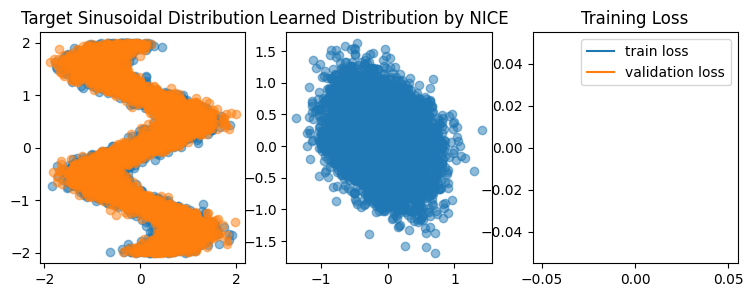

Epoch 50, Loss: 1.8598407864570619, Validation Loss: 1.873562216758728


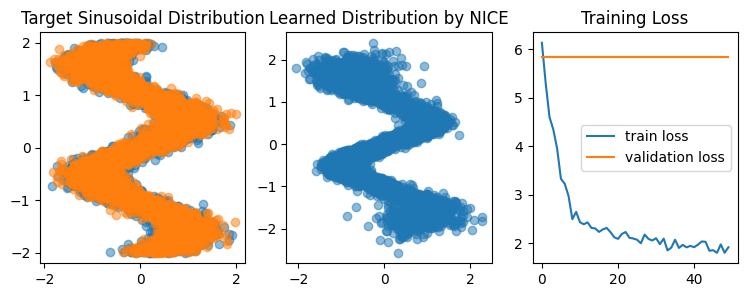

Epoch 100, Loss: 1.7309227585792542, Validation Loss: 1.7481203079223633


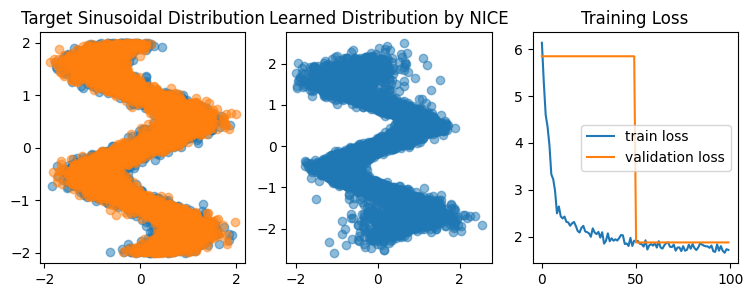

Epoch 150, Loss: 1.717484140396118, Validation Loss: 1.7307579517364502


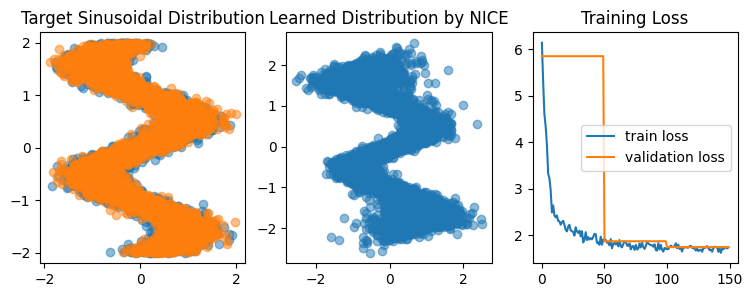

Epoch 200, Loss: 1.7078723311424255, Validation Loss: 1.712430477142334


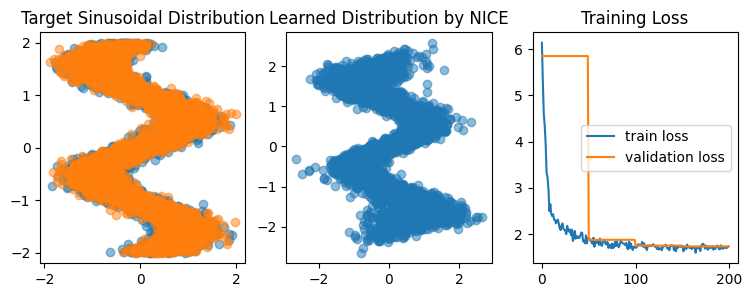

Epoch 250, Loss: 1.686614739894867, Validation Loss: 1.7036491632461548


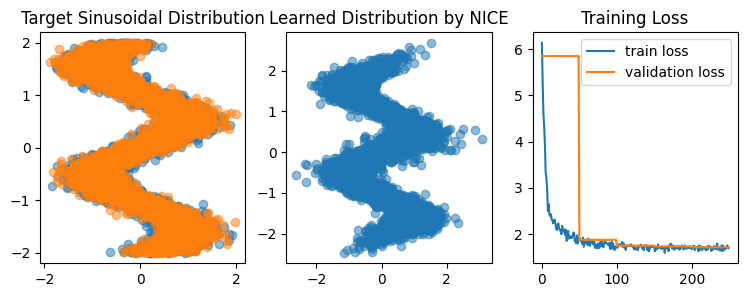

Epoch 300, Loss: 1.6851060271263123, Validation Loss: 1.700149416923523


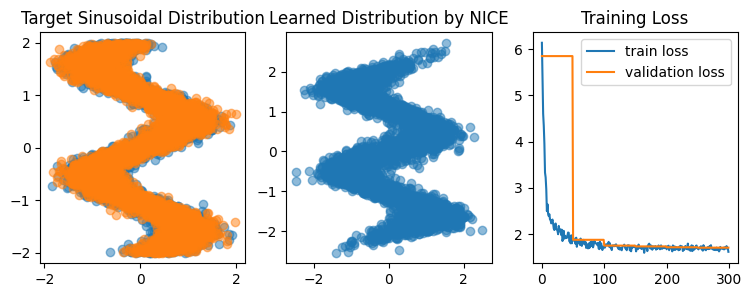

Epoch 350, Loss: 1.6773744583129884, Validation Loss: 1.7014667987823486


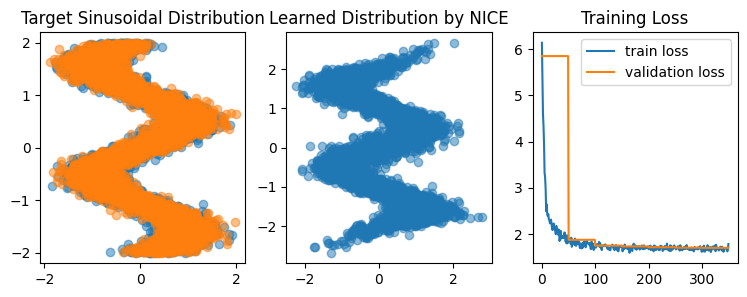

Epoch 400, Loss: 1.6812254667282105, Validation Loss: 1.6940420866012573


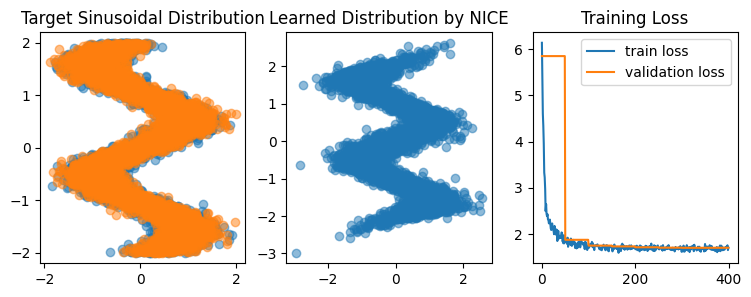

Epoch 450, Loss: 1.6808982729911803, Validation Loss: 1.6972711086273193


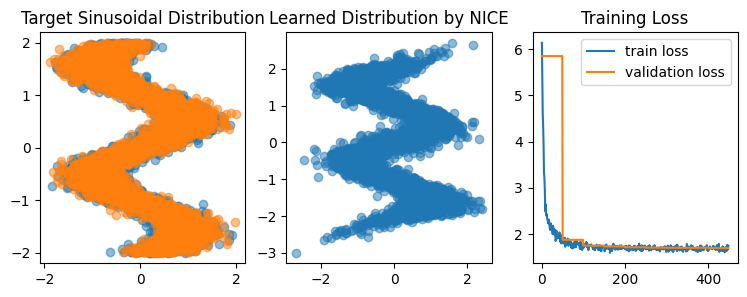

Epoch 500, Loss: 1.679596495628357, Validation Loss: 1.7018312215805054


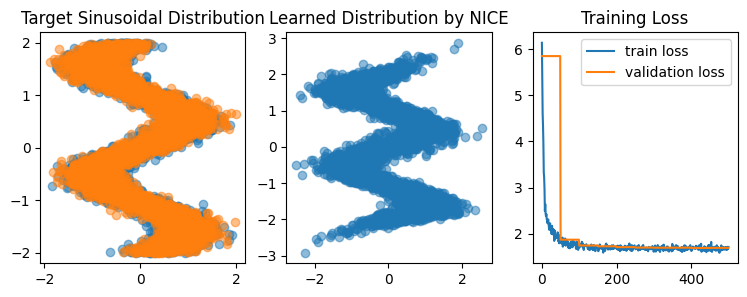

Epoch 550, Loss: 1.677981400489807, Validation Loss: 1.7005128860473633


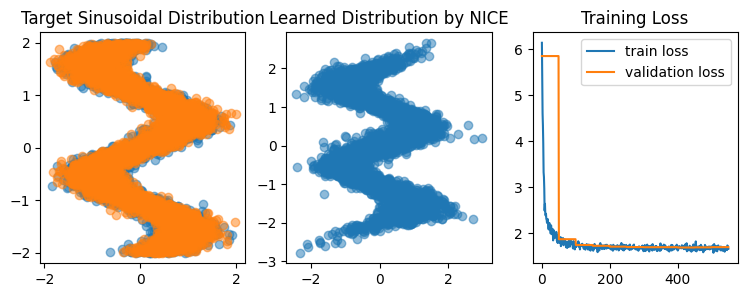

Epoch 600, Loss: 1.6780396819114685, Validation Loss: 1.698824167251587


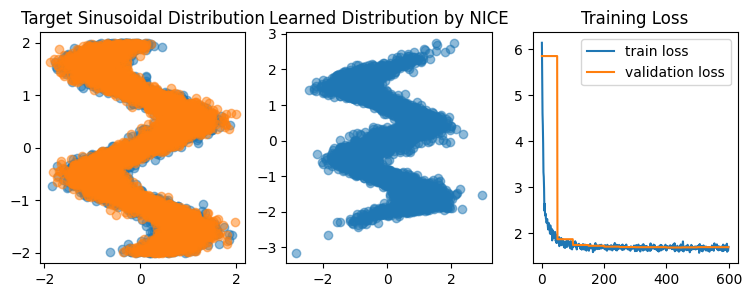

Epoch 650, Loss: 1.6774369478225708, Validation Loss: 1.7171485424041748


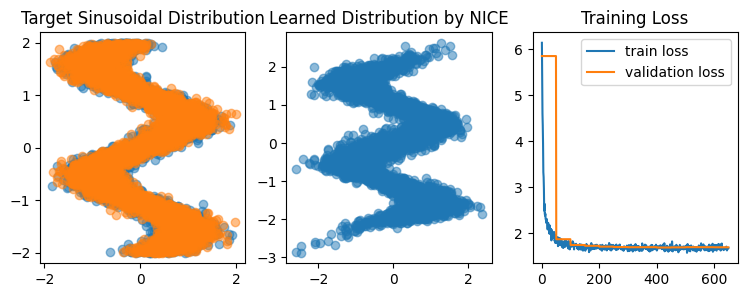

Epoch 700, Loss: 1.686012089252472, Validation Loss: 1.7186148166656494


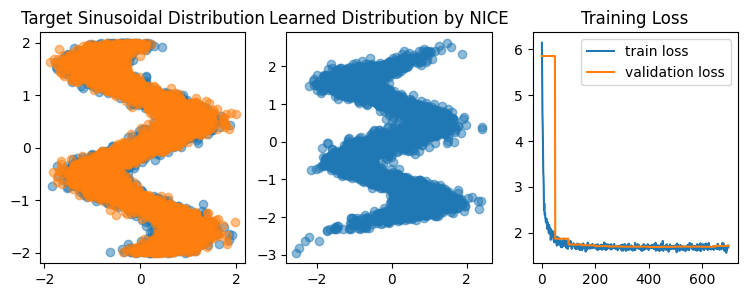

Epoch 750, Loss: 1.6725720763206482, Validation Loss: 1.7093265056610107


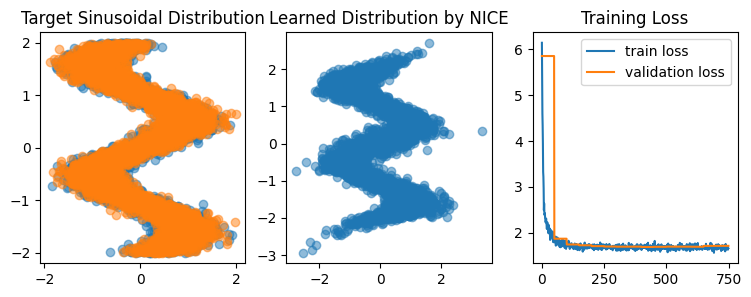

Epoch 800, Loss: 1.6729953169822693, Validation Loss: 1.7027453184127808


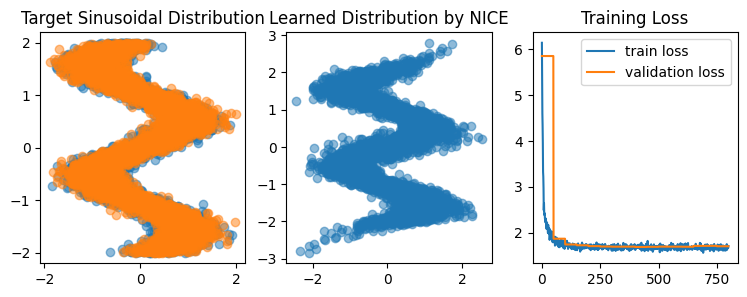

Epoch 850, Loss: 1.6774442434310912, Validation Loss: 1.6993558406829834


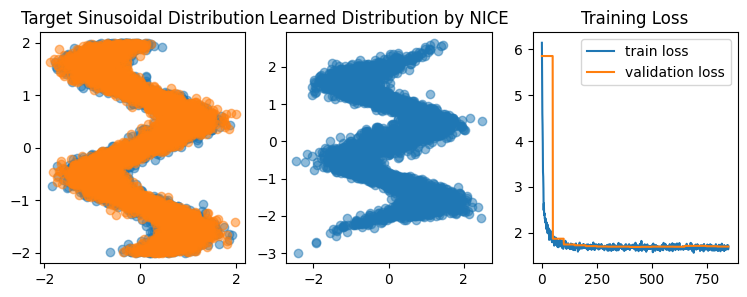

Epoch 900, Loss: 1.6742606163024902, Validation Loss: 1.7009531259536743


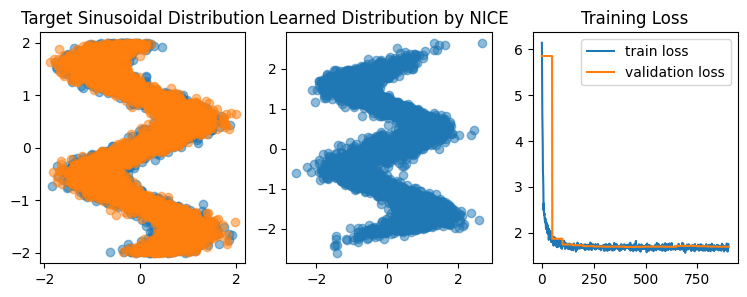

Epoch 950, Loss: 1.6762221693992614, Validation Loss: 1.706798791885376


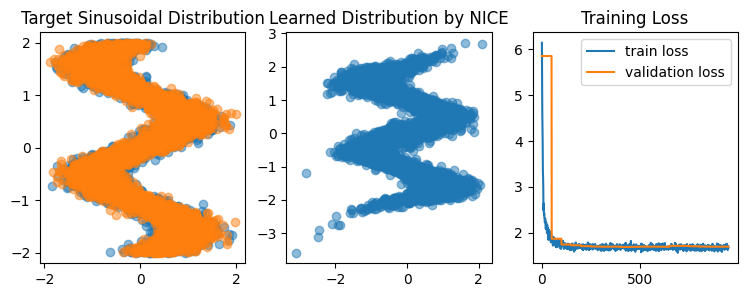

Training completed.


In [6]:
# Training Parameters
num_epochs = 1000
batch_size = 512
learning_rate = 1e-3

# Optimizer
optimizer = torch.optim.Adam(nice_model.parameters(), lr=learning_rate)

# Store losses to plot
train_losses = []
val_losses = []

# Training Loop
for epoch in range(num_epochs):
    perm = torch.randperm(len(training_samples))
    batch_losses = []

    for i in range(0, num_samples//2, batch_size):
        batch_indices = perm[i:i+batch_size]
        batch_samples = training_samples[batch_indices].to(device)
        
        # Forward pass
        log_prob = nice_model.log_prob(batch_samples)
        loss = -torch.mean(log_prob)  # Maximum likelihood estimation
        
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_losses.append(loss.item())
    
    val_loss = None
    if epoch % 50 == 0:
        with torch.no_grad():
            # Compute the validation loss
            val_log_prob = nice_model.log_prob(val_samples.to(device))
            val_loss = -torch.mean(val_log_prob).item()
            print(f'Epoch {epoch}, Loss: {np.mean(batch_losses)}, Validation Loss: {val_loss}')
            

            # Generate samples from the learned model
            learned_samples = nice_model.sample(num_samples).cpu()

        # Plotting
        plt.figure(figsize=(9, 3))

        # Plot target distribution
        plt.subplot(1, 3, 1)
        plt.scatter(training_samples[:, 0], training_samples[:, 1], alpha=0.5, label='train samples')
        plt.scatter(val_samples[:, 0], val_samples[:, 1], alpha=0.5, label='validation samples')
        plt.title('Target Sinusoidal Distribution')

        # Plot learned distribution
        plt.subplot(1, 3, 2)
        plt.scatter(learned_samples[:, 0], learned_samples[:, 1], alpha=0.5)
        plt.title('Learned Distribution by NICE')

        # Plot losses
        plt.subplot(1, 3, 3)
        plt.plot(train_losses, label='train loss')
        plt.plot(val_losses, label='validation loss')
        plt.legend()
        plt.title('Training Loss')

        plt.show()
        
    if val_loss is None:
        val_loss = val_losses[-1]
    train_losses.append(loss.item())
    val_losses.append(val_loss)
print('Training completed.')


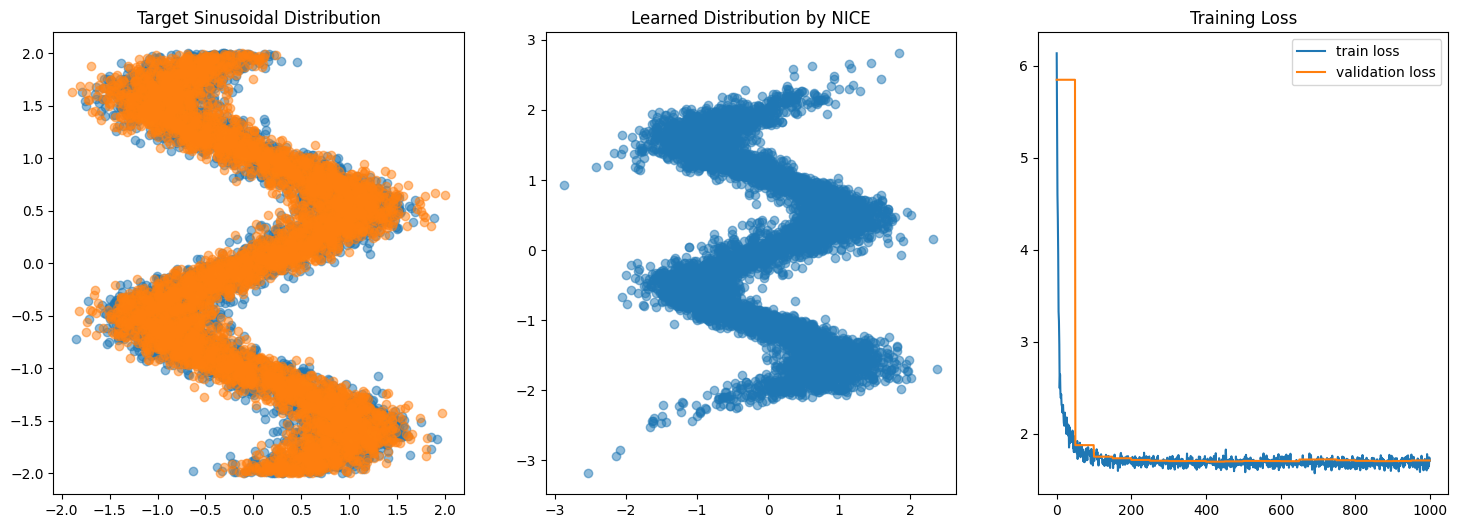

In [7]:
# Generate samples from the learned model
with torch.no_grad():
    learned_samples = nice_model.sample(num_samples).cpu()

# Plotting
plt.figure(figsize=(18, 6))

# Plot target distribution
plt.subplot(1, 3, 1)
plt.scatter(training_samples[:, 0], training_samples[:, 1], alpha=0.5, label='train samples')
plt.scatter(val_samples[:, 0], val_samples[:, 1], alpha=0.5, label='validation samples')
plt.title('Target Sinusoidal Distribution')

# Plot learned distribution
plt.subplot(1, 3, 2)
plt.scatter(learned_samples[:, 0], learned_samples[:, 1], alpha=0.5)
plt.title('Learned Distribution by NICE')

# Plot losses
plt.subplot(1, 3, 3)
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.legend()
plt.title('Training Loss')

plt.show()